# Global analysis

In this section, Why aim to perform a global causal analysis by trying performing a propensity score matching. This will be done by matching samples on the potential confounders we identified in the dataset. Namely the number of languages the movie was translated in, the year of release and a certain similarity in genres.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import networkx as nx
import networkit as nk
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from src.helpers import *
from scipy.stats import normaltest
# import ipywidgets as widgets
# from ipywidgets import interact
pd.options.mode.chained_assignment = None  

In [2]:
gen_data_dir = './generated/'
gender_diversity_file = gen_data_dir + 'gender_diversity.csv'
ethnicity_diversity_file = gen_data_dir + 'ethnicity_diversity.csv'

gender_diverity_df = pd.read_csv(gender_diversity_file)
ethnicity_diversity_df = pd.read_csv(ethnicity_diversity_file)

In [3]:
gender_diverity_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,gender_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/0cc8620,Hemingway & Gellhorn,2012.0,22,"['Romance Film', 'Drama']",0.377164,115,6.000,158,NaN
1,/m/04grkmd,Taking Woodstock,2009.0,22,"['Indie', 'Slice of life story', 'Comedy-drama...",0.409565,87,6.211,405,-0.358824
2,/m/02725hs,Captain Corelli's Mandolin,2001.0,35,"['Film adaptation', 'War film', 'Period piece'...",0.371895,81,5.946,488,1.840898
3,/m/02qr3k8,Terror in the Aisles,1984.0,22,"['Thriller', 'Horror', 'Documentary']",0.491782,78,6.100,37,-0.355676
4,/m/01w8g3,Calendar Girls,2003.0,22,"['Ensemble Film', 'Drama', 'Indie', 'Comedy']",0.492654,66,6.593,350,3.292231


In [4]:
ethnicity_diversity_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,ethnicity_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/031hcx,Harry Potter and the Order of the Phoenix,2007.0,22,"['Mystery', 'Family Film', 'Fantasy Adventure'...",0.744898,28,7.685,18416,7.263377
1,/m/02qr3k8,Terror in the Aisles,1984.0,22,"['Thriller', 'Horror', 'Documentary']",0.850480,27,6.100,37,-0.425137
2,/m/031786,Harry Potter and the Goblet of Fire,2005.0,32,"['Thriller', 'Science Fiction', 'Fantasy Adven...",0.793600,25,7.815,19551,6.908049
3,/m/03l6q0,Scary Movie 3,2003.0,22,"['Parody', 'Horror', 'Absurdism', 'Gross-out f...",0.760417,24,5.977,3815,1.316728
4,/m/011ywj,Gosford Park,2001.0,22,"['Thriller', 'Ensemble Film', 'LGBT', 'Comedy ...",0.548204,23,6.853,997,0.217715


In [5]:
div_df = ethnicity_diversity_df.dropna(subset='movie_release_year').copy()
print('len before dropping : {}\nlen after dropping : {}'.format(len(ethnicity_diversity_df),len(div_df)))

len before dropping : 12640
len after dropping : 12513


In [28]:
## Now we define some utility functions

def common_movie_genre(str1, str2, similarity_rate = 1/3):  #check if two movies have at least one common genre
    # Convert string representation of lists to actual lists
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    intersection_set = len(set1.intersection(set2))

    if intersection_set/max([len(set1),len(set2)]) >= similarity_rate:
        return True
    else:
        return False
    

def same_language_number(sample1, sample2):
    return sample1['movie_languages_count'] == sample2['movie_languages_count']

def same_year(sample1,sample2):
    return sample1['movie_release_year'] == sample2['movie_release_year']


def match_on_attributes(sample1, sample2):
    cond = True
    cond = cond & common_movie_genre(sample1['movie_genres'],sample2['movie_genres'], similarity_rate=1/2)
    return cond

    

def add_propensity_score(df, formula):
    #df = standardize_continuous_features(df)
    mod = smf.ols(formula= formula, data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

def binarize(df, performance_param):
    if performance_param == 'box_office':
        median_value = df['movie_box_office_revenue'].median()
        df['movie_box_office_binary'] = np.where(df['movie_box_office_revenue'] > median_value, 1, 0)
    elif performance_param == 'rating':
        median_value = df['rating_average'].median()
        df['rating_binary'] = np.where(df['rating_average'] > median_value, 1, 0)
    else:
        print("Invalid performance parameter")
        return None
    return df

def compute_balance_df(df, perfomance_param): 
    # Separate the treatment and control groups
    if perfomance_param == 'box_office':
        treatment_df = df[df['movie_box_office_binary'] == 1]
        control_df = df[df['movie_box_office_binary'] == 0]

    elif perfomance_param == 'rating':
        treatment_df = df[df['rating_binary'] == 1]
        control_df = df[df['rating_binary'] == 0]
    else:
        print("Invalid performance parameter")
        return None
    
    print("treatment size:",treatment_df.shape[0])
    print("control size:",control_df.shape[0])

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            if (match_on_attributes(control_row,treatment_row)):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df

def regression(df,formula,performance_param):
    df = add_propensity_score(df, formula)
    df = binarize(df, performance_param)
    balanced_df = compute_balance_df(df,performance_param)
    mod = smf.ols(formula=formula, data=balanced_df)
    res = mod.fit()
    #print(res.summary())
    return balanced_df,mod


def filtering(df, performance_param):
    df_copy = df.copy()
    if (performance_param == 'movie_box_office_revenue'):
        df_copy.dropna(subset=['movie_box_office_revenue'],inplace=True)
        return df_copy

    elif (performance_param == 'rating_average'):
        df_copy.dropna(subset=['rating_average'],inplace=True)
        df_bis = df_copy[df_copy['rating_count'] > 100]
        return df_bis

    else:
        print("Invalid parameters")

## Ethnicity to box office (Full example)

In [29]:


def perform_causal(data, match_on, perf_var, out_df_name = None):

    print('filtering df')

    df = filtering(data,perf_var)
    median_value = df[match_on].median()

    print('computing propensity')

    ## Predictor for propensity scores
    df['treatment'] = np.where(df[match_on] > median_value, 1, 0)
    mod = smf.logit(formula= 'treatment ~ movie_release_year + movie_languages_count', data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    
    print('Creating graph')

    treatment = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]


    ## Max weight matching
    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control.iterrows():
        for treatment_id, treatment_row in treatment.iterrows():
            if (match_on_attributes(control_row,treatment_row)):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    print('performing matching')
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    
    print('saving file')
    file = './generated/' + out_df_name
    balanced_df.to_csv(file)
    return balanced_df

def compute_results(balanced_df, matched_on, perf_var):
    treatment_balanced = balanced_df[balanced_df['treatment'] == 1]
    control_balanced = balanced_df[balanced_df['treatment'] == 0]
    ax = sns.histplot(treatment_balanced[perf_var], kde=True, stat='density', color='blue', label='{High diversity}', log_scale=True)
    ax = sns.histplot(control_balanced[perf_var], kde=True, stat='density', color='orange', label='Low diversity',log_scale=True)
    ax.set(title='{}, after matching'.format(perf_var),xlabel='z-scored {}'.format(perf_var), ylabel='Density')
    plt.legend()
    plt.show()
    mod = smf.ols(formula= '{} ~ C(treatment)'.format(perf_var), data=balanced_df)
    res = mod.fit()
    print(res.summary())




filtering df
computing propensity
Optimization terminated successfully.
         Current function value: 0.643863
         Iterations 6
Creating graph
performing matching
saving file


c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


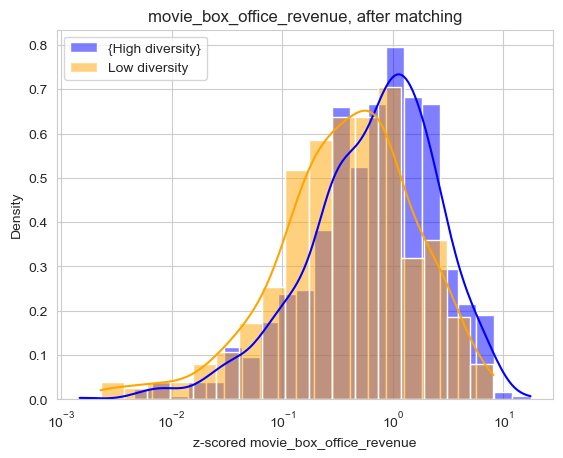

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     183.7
Date:                      Tue, 19 Dec 2023   Prob (F-statistic):           5.38e-41
Time:                              03:34:48   Log-Likelihood:                -6036.3
No. Observations:                      4190   AIC:                         1.208e+04
Df Residuals:                          4188   BIC:                         1.209e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [30]:
perf_var = 'movie_box_office_revenue'
div_var = 'ethnicity_diversity'
test_df = ethnicity_diversity_df.dropna(subset='movie_release_year').copy()
balanced_test = perform_causal(data=test_df,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_EthnDiv')
compute_results(balanced_df=balanced_test,matched_on=div_var,perf_var=perf_var)

filtering df
computing propensity
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 4
Creating graph
performing matching
saving file


c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


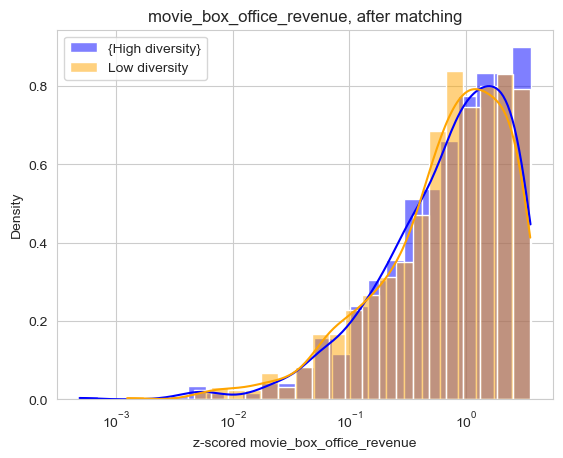

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     7.167
Date:                      Tue, 19 Dec 2023   Prob (F-statistic):            0.00745
Time:                              04:11:55   Log-Likelihood:                -7345.0
No. Observations:                      5194   AIC:                         1.469e+04
Df Residuals:                          5192   BIC:                         1.471e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [32]:
perf_var = 'movie_box_office_revenue'
div_var = 'gender_diversity'
BVG_df = gender_diverity_df.dropna(subset='movie_release_year').copy()
balanced_BVG_df = perform_causal(data=BVG_df,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_GendDiv')
compute_results(balanced_df=balanced_BVG_df,matched_on=div_var,perf_var=perf_var)

filtering df
computing propensity
Optimization terminated successfully.
         Current function value: 0.648252
         Iterations 6
Creating graph
performing matching
saving file


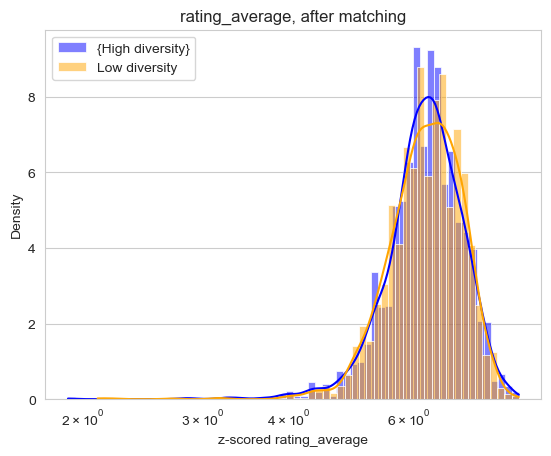

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4653
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.495
Time:                        04:40:49   Log-Likelihood:                -5101.3
No. Observations:                4388   AIC:                         1.021e+04
Df Residuals:                    4386   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.3960      0.01

In [33]:
perf_var = 'rating_average'
div_var = 'ethnicity_diversity'
AVE_df = ethnicity_diversity_df.dropna(subset='movie_release_year').copy()
balanced_AVE_df = perform_causal(data=AVE_df,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_EthnDiv')
compute_results(balanced_df=balanced_AVE_df,matched_on=div_var,perf_var=perf_var)

filtering df
computing propensity
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 4
Creating graph
performing matching
saving file


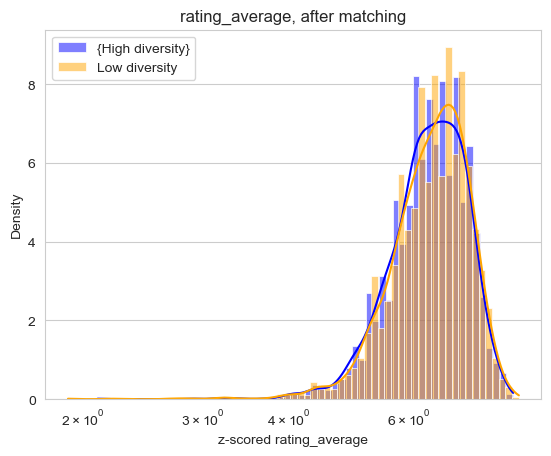

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.196
Date:                Tue, 19 Dec 2023   Prob (F-statistic):             0.0406
Time:                        05:37:06   Log-Likelihood:                -7688.6
No. Observations:                6368   AIC:                         1.538e+04
Df Residuals:                    6366   BIC:                         1.539e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.5018      0.01

In [34]:
perf_var = 'rating_average'
div_var = 'gender_diversity'
AVG_df = gender_diverity_df.dropna(subset='movie_release_year').copy()
balanced_AVG_df = perform_causal(data=AVG_df,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_GendDiv')
compute_results(balanced_df=balanced_AVG_df,matched_on=div_var,perf_var=perf_var)

In [27]:
len(balanced_test)

698

In [9]:
div_df = filtering(div_df,'movie_box_office_revenue')
len(div_df)

4679

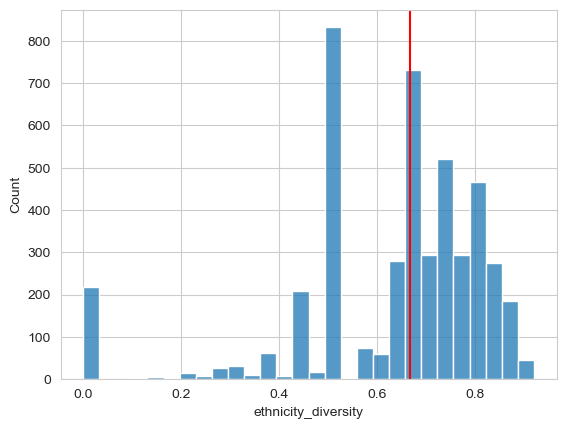

In [10]:
sns.histplot(data = div_df,x='ethnicity_diversity')
median_value = div_df['ethnicity_diversity'].median()
plt.axvline(x=median_value,c='red')
plt.show()

In [24]:
# balanced_global,mod = regression(ethnicity_filtered,'movie_box_office_revenue ~ ethnicity_diversity', 'box_office')

# Binarize the treatment variable. Movies with a diversity above a certain threshold are considered diverse while others will be set as control
div_df['treatment'] = np.where(div_df['ethnicity_diversity'] > median_value, 1, 0)
mod = smf.logit(formula= 'treatment ~ movie_release_year + movie_languages_count', data=div_df)
res = mod.fit()
div_df['Propensity_score'] = res.predict()
treatment = div_df[div_df['treatment'] == 1]
control = div_df[div_df['treatment'] == 0]

Optimization terminated successfully.
         Current function value: 0.643863
         Iterations 6


In [12]:

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treatment.iterrows():
        if (match_on_attributes(control_row,treatment_row)):
            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df = div_df.loc[matched]


In [13]:
len(balanced_df)

698

In [14]:
balanced_df.to_csv('balanced2.csv')

In [15]:
balanced_df_loaded = pd.read_csv('balanced2.csv')

In [16]:
treatment_balanced = balanced_df_loaded[balanced_df_loaded['treatment'] == 1]
control_balanced = balanced_df_loaded[balanced_df_loaded['treatment'] == 0]

c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


c:\Users\David\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


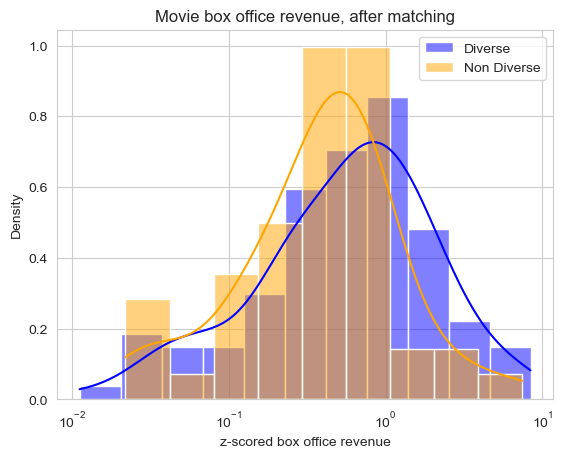

In [17]:
ax = sns.histplot(treatment_balanced['movie_box_office_revenue'], kde=True, stat='density', color='blue', label='Diverse',log_scale=True)
ax = sns.histplot(control_balanced['movie_box_office_revenue'], kde=True, stat='density', color='orange', label='Non Diverse',log_scale=True)
ax.set(title='Movie box office revenue, after matching',xlabel='z-scored box office revenue', ylabel='Density')
plt.legend()
plt.show()

<Axes: xlabel='ethnicity_diversity', ylabel='movie_box_office_revenue'>

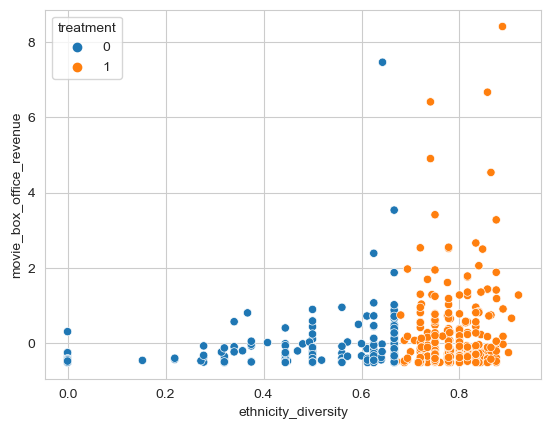

In [18]:
sns.scatterplot(data=balanced_df_loaded,x='ethnicity_diversity',y='movie_box_office_revenue',hue='treatment')

In [19]:
mod = smf.ols(formula= 'movie_box_office_revenue ~ C(treatment)', data=balanced_df_loaded)
res = mod.fit()
print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.031
Model:                                  OLS   Adj. R-squared:                  0.030
Method:                       Least Squares   F-statistic:                     22.28
Date:                      Tue, 19 Dec 2023   Prob (F-statistic):           2.86e-06
Time:                              02:27:56   Log-Likelihood:                -860.39
No. Observations:                       698   AIC:                             1725.
Df Residuals:                           696   BIC:                             1734.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------